# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [32]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

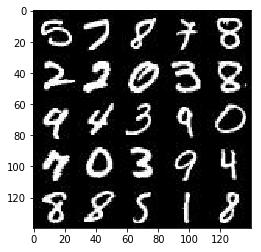

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

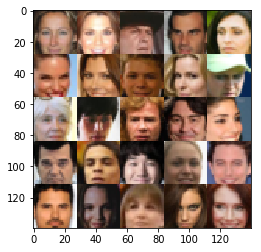

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                'real_inputs')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [37]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, 2, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [38]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*512)
        h1 = tf.reshape(h1, (-1, 2, 2, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, 256, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, 128, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [39]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [40]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [42]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        z_input: z_sample, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 2.7144
Epoch 1/2... Discriminator Loss: 2.9682... Generator Loss: 3.0791
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 3.9243
Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 3.7835
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 3.7337
Epoch 1/2... Discriminator Loss: 1.2907... Generator Loss: 3.2334
Epoch 1/2... Discriminator Loss: 1.5328... Generator Loss: 1.2417
Epoch 1/2... Discriminator Loss: 1.1194... Generator Loss: 0.4460
Epoch 1/2... Discriminator Loss: 0.8874... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 1.2463


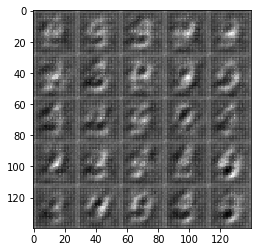

Epoch 1/2... Discriminator Loss: 0.9703... Generator Loss: 2.1679
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 1.5805
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.3897
Epoch 1/2... Discriminator Loss: 1.1118... Generator Loss: 1.4928
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.0965
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 1.3915


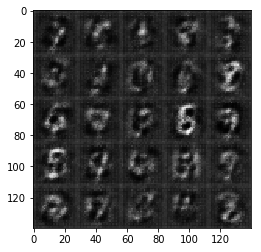

Epoch 1/2... Discriminator Loss: 1.0434... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 1.1509... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.8687... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 1.0680... Generator Loss: 1.6311
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 0.7669... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.5251
Epoch 1/2... Discriminator Loss: 0.7707... Generator Loss: 1.2948


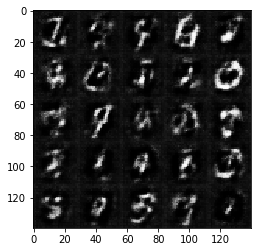

Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.3707
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.3009
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 1.2701
Epoch 1/2... Discriminator Loss: 0.7812... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 0.8321... Generator Loss: 1.4810
Epoch 1/2... Discriminator Loss: 0.6806... Generator Loss: 1.1316
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 1.6159
Epoch 1/2... Discriminator Loss: 0.7908... Generator Loss: 0.9918
Epoch 1/2... Discriminator Loss: 0.7231... Generator Loss: 1.6237


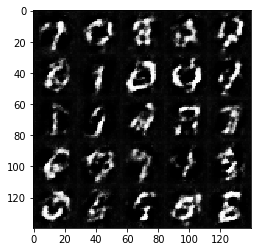

Epoch 1/2... Discriminator Loss: 0.7248... Generator Loss: 1.2362
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 1.2720
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 1.5740
Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 1.4622
Epoch 1/2... Discriminator Loss: 0.8332... Generator Loss: 1.3438
Epoch 1/2... Discriminator Loss: 0.7855... Generator Loss: 1.5484
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.3595
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.3110
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.3533
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.4883


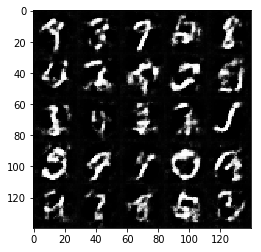

Epoch 1/2... Discriminator Loss: 0.8644... Generator Loss: 1.5362
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.5557
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 0.9936... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.6567
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.6303
Epoch 1/2... Discriminator Loss: 0.8336... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 0.7389... Generator Loss: 1.2707
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 1.3736


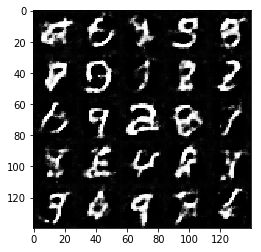

Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.4894
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 1.2615
Epoch 1/2... Discriminator Loss: 0.7239... Generator Loss: 1.3022
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 1.3671
Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.8567... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.3114... Generator Loss: 0.2470
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 0.2572


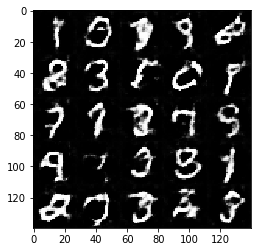

Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 0.2812
Epoch 1/2... Discriminator Loss: 0.7609... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.1341
Epoch 1/2... Discriminator Loss: 0.7421... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.4206
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.2207
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.3289
Epoch 1/2... Discriminator Loss: 1.1631... Generator Loss: 0.3400
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 0.7114


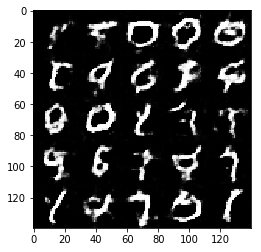

Epoch 1/2... Discriminator Loss: 0.7348... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.2205
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 0.5572
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.2188
Epoch 1/2... Discriminator Loss: 1.0403... Generator Loss: 0.3812
Epoch 1/2... Discriminator Loss: 0.6605... Generator Loss: 0.7170
Epoch 1/2... Discriminator Loss: 0.5776... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 0.5762... Generator Loss: 1.1977
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 0.6415... Generator Loss: 0.6557


Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.2816... Generator Loss: 0.2191
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.3082
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 1.6353... Generator Loss: 0.1308
Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 0.8915
Epoch 2/2... Discriminator Loss: 0.5761... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 0.6397... Generator Loss: 0.5434
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.3005


Epoch 2/2... Discriminator Loss: 0.6678... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 0.9185... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 0.2433
Epoch 2/2... Discriminator Loss: 0.9337... Generator Loss: 0.3630
Epoch 2/2... Discriminator Loss: 0.5330... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 0.3237... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 0.7238... Generator Loss: 1.1880
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 0.6112
Epoch 2/2... Discriminator Loss: 0.5484... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.4190


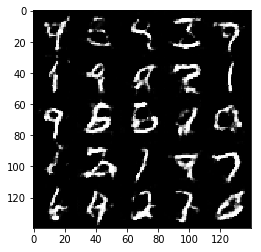

Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 0.4898
Epoch 2/2... Discriminator Loss: 0.3695... Generator Loss: 1.1219
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 0.5450... Generator Loss: 1.3124
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 0.5100
Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 3.0157
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 2.0066
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 0.4565
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 0.7634
Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.2624


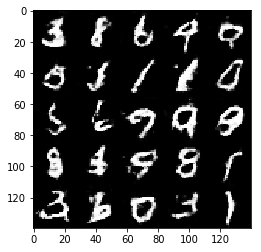

Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 3.0515... Generator Loss: 0.0597
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 0.7542... Generator Loss: 1.8284
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 0.6169
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.6869
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.3212
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 1.4569
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.3540


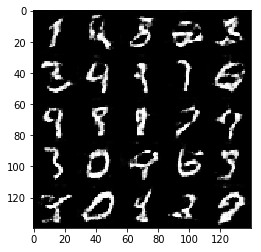

Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.2765
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: -0.0506... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.1976
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.2743
Epoch 2/2... Discriminator Loss: 1.7269... Generator Loss: 0.1515
Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 0.3403... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 1.5043


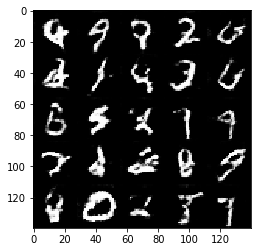

Epoch 2/2... Discriminator Loss: 0.5003... Generator Loss: 1.4088
Epoch 2/2... Discriminator Loss: 0.3582... Generator Loss: 1.6874
Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 0.4088... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 0.5415... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 2.1703
Epoch 2/2... Discriminator Loss: 0.6067... Generator Loss: 1.5549
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 0.1426... Generator Loss: 0.8260


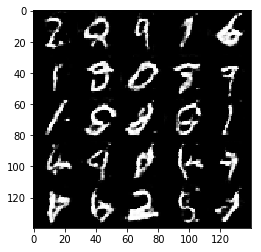

Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 0.3987... Generator Loss: 0.6008
Epoch 2/2... Discriminator Loss: 5.3754... Generator Loss: 7.0852
Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 2.6742
Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 0.1947... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 0.6196... Generator Loss: 0.9669
Epoch 2/2... Discriminator Loss: 0.6628... Generator Loss: 1.7891


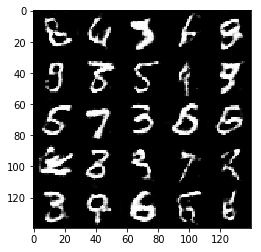

Epoch 2/2... Discriminator Loss: 0.3291... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 0.2796... Generator Loss: 0.9691
Epoch 2/2... Discriminator Loss: 0.6971... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 0.1866... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 0.4924... Generator Loss: 0.4925
Epoch 2/2... Discriminator Loss: 2.0226... Generator Loss: 0.1311
Epoch 2/2... Discriminator Loss: 1.2408... Generator Loss: 0.2508
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.4021
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 0.5564
Epoch 2/2... Discriminator Loss: 0.2094... Generator Loss: 0.9087


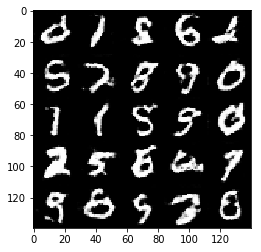

Epoch 2/2... Discriminator Loss: 0.3261... Generator Loss: 0.8911
Epoch 2/2... Discriminator Loss: 0.1940... Generator Loss: 1.6594
Epoch 2/2... Discriminator Loss: 0.6490... Generator Loss: 2.2507
Epoch 2/2... Discriminator Loss: 0.6070... Generator Loss: 0.6675
Epoch 2/2... Discriminator Loss: 0.0404... Generator Loss: 1.3063
Epoch 2/2... Discriminator Loss: 0.3846... Generator Loss: 0.6581
Epoch 2/2... Discriminator Loss: 0.3012... Generator Loss: 1.4333
Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.7101
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 0.2686... Generator Loss: 0.8139


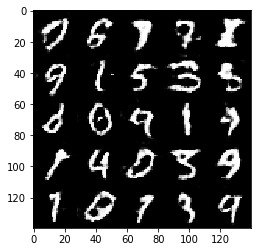

Epoch 2/2... Discriminator Loss: -0.1326... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 0.4318
Epoch 2/2... Discriminator Loss: 3.6880... Generator Loss: 0.0206
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.3270
Epoch 2/2... Discriminator Loss: 0.2517... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.4170
Epoch 2/2... Discriminator Loss: 1.0624... Generator Loss: 0.3035


In [43]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2399... Generator Loss: 0.0428
Epoch 1/1... Discriminator Loss: 2.0373... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 1.7777... Generator Loss: 6.6743
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 2.2472
Epoch 1/1... Discriminator Loss: 2.7587... Generator Loss: 9.9978
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 2.4693
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8888


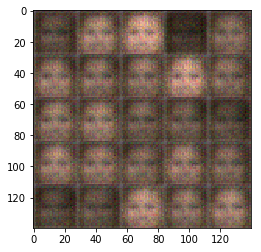

Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.2324
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 1.1955
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.6593


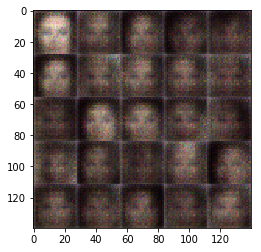

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.1970
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8547


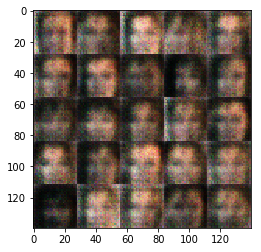

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 1.1800
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.1845


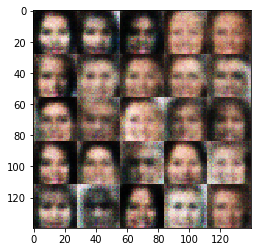

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 1.5832
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.4461


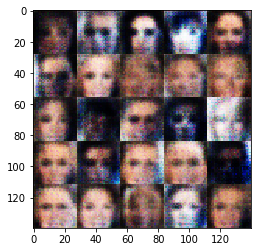

Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.6669
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 1.4659
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8880


Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.1779
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.5474
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 1.3283
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.3229


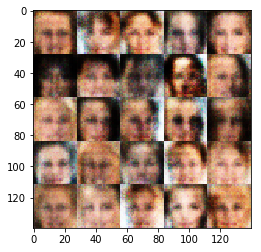

Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 1.5425
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 1.5296
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 1.4228
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 1.2691


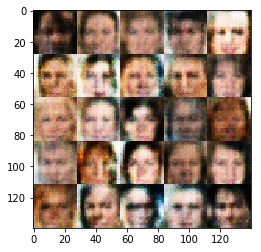

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.4571
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.3199
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.2107
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 1.7096
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.4265


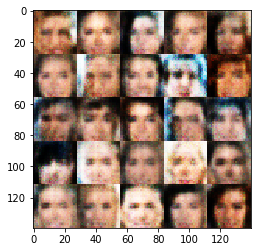

Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8056


Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.5741
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8283


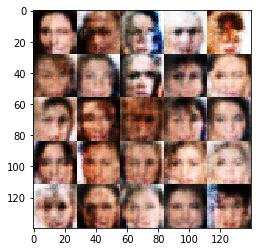

Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.5401
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 1.2226


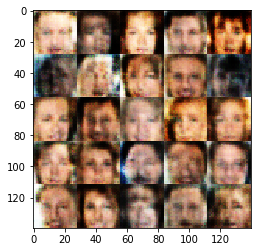

Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 1.7457
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 1.9827
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 1.7737
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.9681
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 2.1103
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.9179
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 1.1607


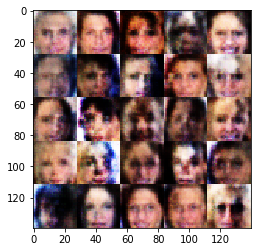

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1272
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.9835
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.1611
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 2.0199


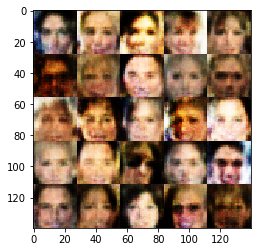

Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 1.7284... Generator Loss: 3.2525
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.5945... Generator Loss: 0.4860
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.9770


Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 2.3699
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 2.0111
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.8298
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 2.3378
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 2.4672


Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 1.0060
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 2.3104
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 1.4955
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 1.5697
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 2.0015
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.1786


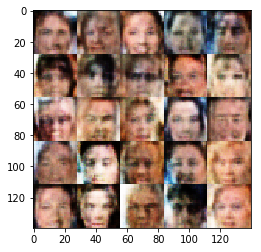

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 1.7746
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 1.7596
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.1890
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.2075


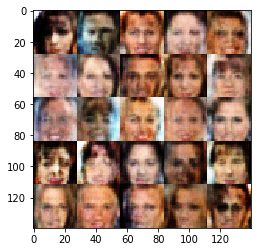

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.3775
Epoch 1/1... Discriminator Loss: 1.9173... Generator Loss: 2.6040
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 1.7212
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 1.1980


Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.2446
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.9026
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.3432
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.4824
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.9913


Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 1.1147
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.1287


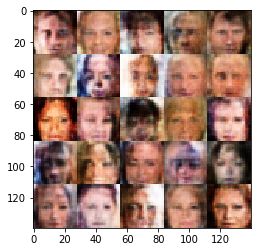

Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.3525
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6308


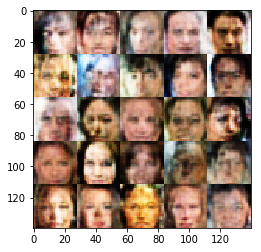

Epoch 1/1... Discriminator Loss: 1.8508... Generator Loss: 2.4601
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.4861
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.7674


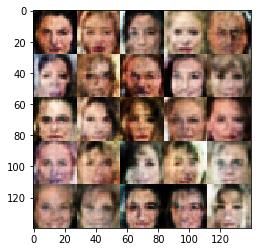

Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.0673
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.9533
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0228


Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.9828
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1721
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 1.9668
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.9280


Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 1.8193
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.4176


Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 1.1656
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 1.6987
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.4544
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.8774
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9231
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.7762


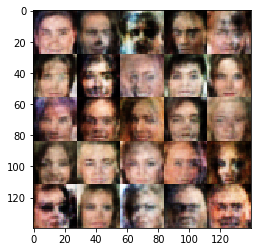

Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.6534
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 2.0724
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5936


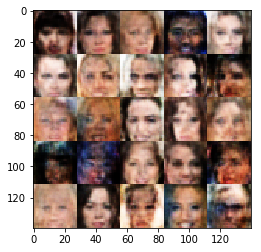

Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.6141
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.5550


Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.7297
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.0106
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.6124


Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.9999
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.6588
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.0383


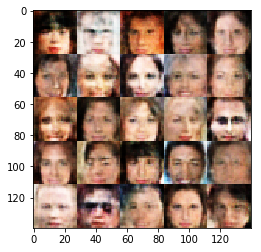

Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9461


In [44]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.